# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [94]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

## Create directory to save output files

In [3]:
# create name for results folder where output files will be saved
resultsFolder = "results_minCorrelation_0o2"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load previous results (skip if results have not previously been generated)

In [4]:
# If previous results exist, use miner.read_json to load them
# revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
# regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
# mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))
# regulonDf = pd.read_csv(os.path.join(resultsDirectory,"regulonDf.csv"),index_col=0,header=0)
# overExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"),index_col=0,header=0)
# underExpressedMembersMatrix = pd.read_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"),index_col=0,header=0)
# coherent_samples_matrix = pd.read_csv(os.path.join(resultsDirectory,"coherentMembers.csv"),index_col=0,header=0)

## Load reference dictionary for mechanistic inference (skip if using default)

In [ ]:
# provide absolute path to your .csv-format reference database
# filename = os.path.join(os.path.split(os.getcwd())[0],"data","reference_database_example.csv")
# provide absolute path to the miner/data/network_dictionaries directory where your database will be stored
# network_dictionaries_path = os.path.join(os.path.split(os.getcwd())[0],"data","network_dictionaries")
# name your reference database and use the extension ".pkl"
# dictionaryName = "reference_database.pkl"
# import and save your reference database to the Python pickle format for future use
# reference_mechanistic_database = miner.fileToReferenceDictionary(filename,os.path.join(network_dictionaries_path,dictionaryName))

# 0. Load and pre-process data; set parameters

In [134]:
# Load expression Data
expressionFile = os.path.join(os.path.split(os.getcwd())[0],"data","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

completed identifier conversion.
16216 genes were converted.


In [ ]:
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",FontSize=14)
plt.ylabel("Relative expression",FontSize=14)
plt.xlabel("Sample ID",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)

## Set parameters

In [ ]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

In [ ]:
reload(miner)
t1 = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# ensure that keys have type str

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(expressionData.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t2 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t2-t1)/60.))

# 2. Mechanistic inference

In [ ]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

In [ ]:
regulon_id = 10
regulonDf[regulonDf.Regulon_ID==str(regulon_id)]

# 3. Causal inference

In [ ]:
# Load mutation matrices
common_mutations_file = os.path.join(os.path.split(os.getcwd())[0],"data","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(os.path.split(os.getcwd())[0],"data","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(os.path.split(os.getcwd())[0],"data","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [ ]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

In [ ]:
# generate output for web portal visualization
wiringDiagramOutput = os.path.join(resultsDirectory,"wiring_diagram.csv")
wireDiagram = wiringDiagram(causal_results,regulonModules,coherent_samples_matrix,include_genes=False,savefile=wiringDiagramOutput)
wireDiagram.head()

# 4. Network mapping

In [179]:
reload(miner)
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 1.57 minutes


In [ ]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 5. Subtype discovery

done!
Discovered 20 transcriptional states and 28 transcriptional programs
sample coverage within sufficiently large states: 99.8%
completed subtype inference in 1.50 minutes


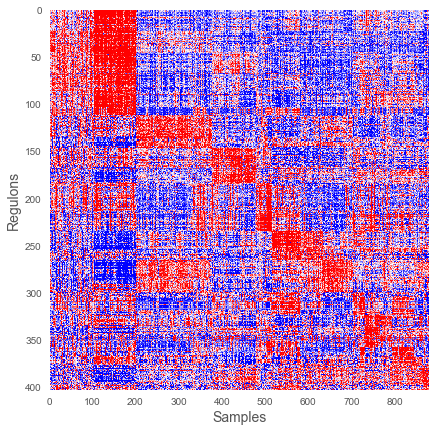

In [142]:
reload(miner)
t1 = time.time()
# choose membership type for sample class prediction
predictiveRegulons = overExpressedMembersMatrix.index #np.array(non_zero_regulons).astype(str)
sampleDictionary = {key:overExpressedMembers[key] for key in predictiveRegulons}
sampleMatrix = overExpressedMembersMatrix.loc[np.array(non_zero_regulons).astype(str),:]
sampleUnderMatrix = underExpressedMembersMatrix.loc[np.array(non_zero_regulons).astype(str),:]

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
#miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
#miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Regulons",resultsDirectory=None,showplot=False)
orderedDM = miner.plotDifferentialMatrix(sampleMatrix,sampleUnderMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"),showplot=False)
reference_df = eigengenes.loc[np.array(non_zero_regulons).astype(str),:]

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=reference_df,programs=program_list,states=states,stateThreshold=0.65,saveFile=None)

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=None)

t2 = time.time()
print("completed subtype inference in {:.2f} minutes".format((t2-t1)/60.))

# 6. Risk prediction

## 6a. Risk by subtype

19
10
                               HR       p-value
8                        7.894696  2.910237e-15
8&12&13                  7.764199  8.216308e-15
8&12                     7.750245  9.171513e-15
8&12&13&9                7.106597  1.189391e-12
8&12&13&9&16             6.600562  4.096030e-11
8&12&13&9&16&7           6.399044  1.563531e-10
8&12&13&9&16&7&4         6.121546  9.267200e-10
8&12&13&9&16&7&4&0       5.582625  2.369159e-08
8&12&13&9&16&7&4&0&1     5.028311  4.948198e-07
18                      -1.828160  6.752553e-02
18&14                   -2.526025  1.153614e-02
18&14&2                 -4.409255  1.037270e-05
18&14&2&17              -4.804524  1.551200e-06
18&14&2&17&10&15&11&6&3 -4.937911  7.896385e-07
18&14&2&17&10           -5.074030  3.894782e-07
18&14&2&17&10&15        -5.133887  2.838188e-07
18&14&2&17&10&15&11&6   -5.256648  1.467047e-07
18&14&2&17&10&15&11     -5.325707  1.005611e-07
completed combinatorial transcriptional state survival analysis in 0.54 minutes


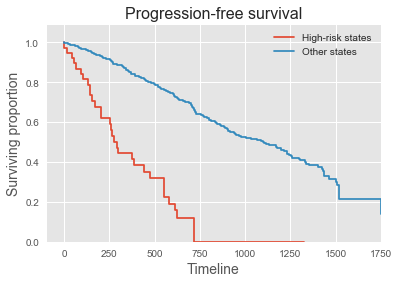

In [146]:
t1 = time.time()

# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = [i for i in states if len(set(srv.index)&set(i)) >= 5]
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"

# Combinatorial survival analysis
combined_states, combined_indices = miner.combinedStates(mmrf_groups,ranked_states,srv,minSamples=4,maxStates=10)

state_members = combined_states
sufficient_states = range(len(combined_states))
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_combined_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=1,survivalPath="",survivalData=srv)

cox_hr = [cox_combined_states[i][0] for i in cox_combined_states.keys()]
cox_p = [cox_combined_states[i][1] for i in cox_combined_states.keys()]
cox_combined_states_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_combined_states_df.index = combined_indices
cox_combined_states_df.columns = ["HR","p-value"]
cox_combined_states_df.sort_values(by="HR",ascending=False,inplace=True)
cox_combined_states_df.to_csv(os.path.join(resultsDirectory,"Hazards_regression_of_combined_transcriptional_states.csv"))
print(cox_combined_states_df)

highest_risk_combination = np.array(cox_combined_states_df.index[0].split("&")).astype(int)
lowest_risk_combination = np.array(cox_combined_states_df.index[-1].split("&")).astype(int)

kmTag = "states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [np.hstack([mmrf_groups[i] for i in highest_risk_combination]),np.hstack([mmrf_groups[i] for i in range(len(mmrf_groups)) if i not in highest_risk_combination])]
labels = np.arange(len(groups)).astype(str)
labels = ["High-risk states","Other states"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)  

t2 = time.time()
print("completed combinatorial transcriptional state survival analysis in {:.2f} minutes".format((t2-t1)/60.))

## 6b. Risk by machine-learning classification

## Load expression data

In [5]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!


## Load survival data

In [6]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

# GSE24080UAMS
survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]
kmDfGSE24080UAMS = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDfGSE24080UAMS)

# GSE19784HOVON65 
survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]
kmDfGSE19784HOVON65 = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDfGSE19784HOVON65)

# EMTAB4032
survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]
kmDfEMTAB4032 = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDfEMTAB4032)

# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Pre-process data for classification

In [7]:
hrMatrixMMRF, lrMatrixMMRF = miner.generatePredictionMatrix(guanSurvivalDfMMRF.copy(),overExpressedMembersMatrix.copy(),high_risk_cutoff = 0.2)
hrMatrixGSE24080UAMS, lrMatrixGSE24080UAMS = miner.generatePredictionMatrix(guanSurvivalDfGSE24080UAMS.copy(),overExpressedMembersMatrixGSE24080UAMS.copy(),high_risk_cutoff = 0.2)
hrMatrixGSE19784HOVON65, lrMatrixGSE19784HOVON65 = miner.generatePredictionMatrix(guanSurvivalDfGSE19784HOVON65.copy(),overExpressedMembersMatrixGSE19784HOVON65.copy(),high_risk_cutoff = 0.2)
hrMatrixEMTAB4032, lrMatrixEMTAB4032 = miner.generatePredictionMatrix(guanSurvivalDfEMTAB4032.copy(),overExpressedMembersMatrixEMTAB4032.copy(),high_risk_cutoff = 0.2)

hrMatrixCombined = pd.concat([hrMatrixMMRF,hrMatrixGSE24080UAMS,hrMatrixGSE19784HOVON65,hrMatrixEMTAB4032],axis=0) 
lrMatrixCombined = pd.concat([lrMatrixMMRF,lrMatrixGSE24080UAMS,lrMatrixGSE19784HOVON65,lrMatrixEMTAB4032],axis=0) 
predictionMatrix = pd.concat([hrMatrixCombined,lrMatrixCombined],axis=0)
predictionMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3194,3195,3196,3197,3198,3199,3200,3201,3202,HR_FLAG
MMRF_2754_1_BM,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1
MMRF_2151_1_BM,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
MMRF_1450_1_BM,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
MMRF_1634_1_BM,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
MMRF_1778_1_BM,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Generate XGBoost models

In [68]:
# generate decision-trees from random predictionMatrix training sets

X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

best_state = 0
best_f1 = 0
best_auc = 0
aucs = []
for rs in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = rs)
    clf_xgboost = XGBClassifier(n_jobs=1,random_state=12)
    clf_xgboost.fit(X_train, y_train)

    y_pred = clf_xgboost.predict(X_test)
    y_pred2 = clf_xgboost.predict_proba(X_test)[:,1]
    
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred2)
    aucs.append(auc)

    #print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
    print("F1-score is ", f1)
    print("ROC AUC is ", auc)
    
    if f1 > best_f1:
        best_f1 = f1
        
    if auc > best_auc:
        best_auc = auc        
        best_state = rs

print(rs,best_state,best_auc)    
print(np.argsort(-np.array(aucs)))

('F1-score is ', 0.2675159235668789)
('ROC AUC is ', 0.6604882154882155)
('F1-score is ', 0.25675675675675674)
('ROC AUC is ', 0.6725399837354298)
('F1-score is ', 0.3125)
('ROC AUC is ', 0.6974984451661944)
('F1-score is ', 0.24242424242424243)
('ROC AUC is ', 0.6730963346161125)
('F1-score is ', 0.27672955974842767)
('ROC AUC is ', 0.6557533375715194)
('F1-score is ', 0.2251655629139073)
('ROC AUC is ', 0.6367521367521367)
('F1-score is ', 0.2597402597402597)
('ROC AUC is ', 0.696462455950122)
('F1-score is ', 0.3550295857988166)
('ROC AUC is ', 0.6610348297464861)
('F1-score is ', 0.24516129032258063)
('ROC AUC is ', 0.6237056513130133)
('F1-score is ', 0.29239766081871343)
('ROC AUC is ', 0.6617976433927354)
('F1-score is ', 0.32258064516129037)
('ROC AUC is ', 0.6823523146833286)
('F1-score is ', 0.3170731707317074)
('ROC AUC is ', 0.6674196463147024)
('F1-score is ', 0.3488372093023256)
('ROC AUC is ', 0.6963664784508884)
('F1-score is ', 0.2976190476190476)
('ROC AUC is ', 0.631

## Select optimal XGBoost model

In [124]:
X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 16)
clf_xgboost = XGBClassifier(n_jobs=1,random_state=12)
clf_xgboost.fit(X_train, y_train)

y_pred = clf_xgboost.predict(X_test)
y_pred2 = clf_xgboost.predict_proba(X_test)[:,1]

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
print("F1-score is ", f1_score(y_test,y_pred))
print("ROC AUC is ", roc_auc_score(y_test,y_pred2))

('Accuracy is ', 83.41463414634146)
('F1-score is ', 0.29166666666666663)
('ROC AUC is ', 0.6974297019995097)


## Generate decision-trees

In [ ]:
# generate decision-trees from random predictionMatrix training sets

X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

best_state = 0
best_f1 = 0
best_auc = 0
aucs = []
for rs in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = rs)
    clf_dt = DecisionTreeClassifier(criterion = "gini", random_state = 12, max_depth=6, min_samples_leaf=5)#12    
    clf_dt.fit(X_train, y_train)

    y_pred = clf_dt.predict(X_test)
    y_pred2 = clf_dt.predict_proba(X_test)[:,1]
    
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred2)
    aucs.append(auc)

    #print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
    print("F1-score is ", f1)
    print("ROC AUC is ", auc)
    
    if f1 > best_f1:
        best_f1 = f1
        
    if auc > best_auc:
        best_auc = auc        
        best_state = rs

print(best_state,best_auc)    
print(np.argsort(-np.array(aucs)))

## Select optimal decision-tree

In [34]:
X = np.array(predictionMatrix.iloc[:,0:-1])
Y = np.array(predictionMatrix.iloc[:,-1])
X = X.astype('int')
Y = Y.astype('int')

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.35, random_state = 6) #75
clf_dt = DecisionTreeClassifier(criterion = "gini", random_state = 12, max_depth=6, min_samples_leaf=5)
clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)
y_pred2 = clf_dt.predict_proba(X_test)[:,1]

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
print("F1-score is ", f1_score(y_test,y_pred))
print("ROC AUC is ", roc_auc_score(y_test,y_pred2))

('Accuracy is ', 79.02439024390245)
('F1-score is ', 0.2275449101796407)
('ROC AUC is ', 0.5579171184602874)


## Visualize decision-tree

In [ ]:
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 
from graphviz import Source

dot_data = StringIO() 
tree.export_graphviz(clf_dt, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf(os.path.join(resultsDirectory,"decisionTreeAUC.pdf"))

# visualize decision tree
graph[0].set_graph_defaults(size = "\"15,15\"")
decisionTree = Source(graph[0].to_string())
decisionTree

## Evaluate performance of predictor

classifier has integrated AUC of 0.847
Risk stratification of MMRF has Hazard Ratio of 16.01
classifier has integrated AUC of 0.916
Risk stratification of GSE24080UAMS has Hazard Ratio of 14.44
classifier has integrated AUC of 0.793
Risk stratification of GSE19784HOVON65 has Hazard Ratio of 10.28
classifier has integrated AUC of 0.635
Risk stratification of EMTAB4032 has Hazard Ratio of 8.32


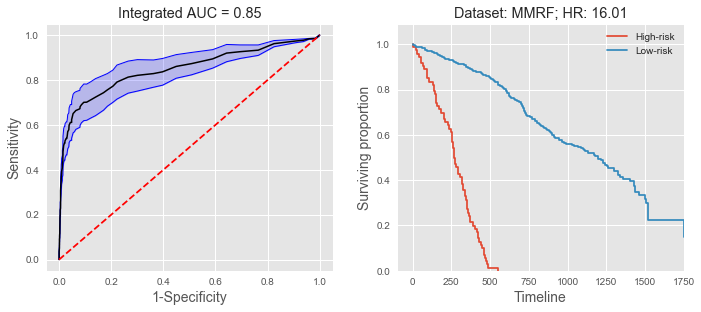

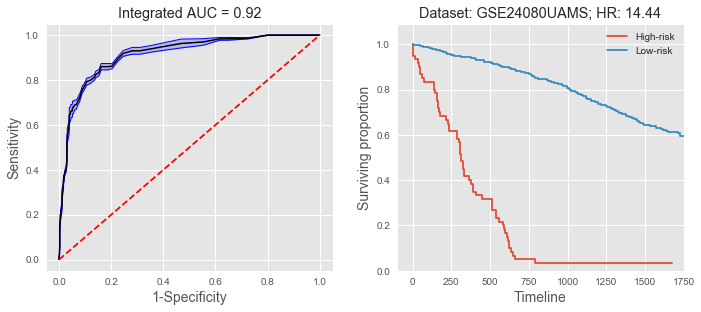

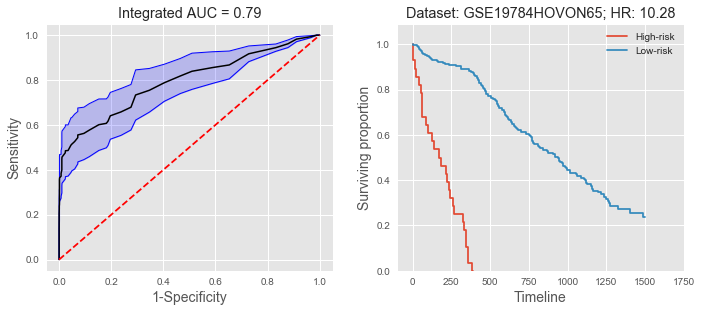

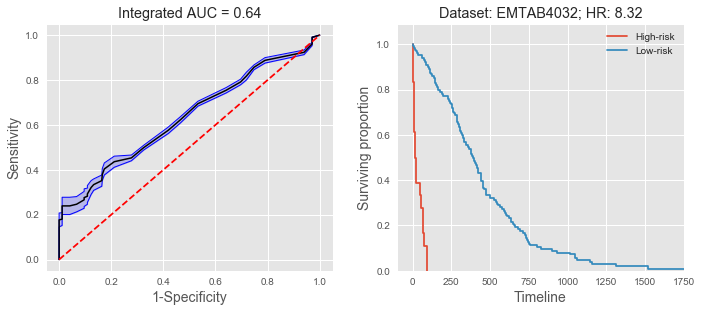

In [232]:
# generate predictions for each dataset
predictor_tag = "IA12"
classifier = clf_xgboost
mmrfIA12_predictions = classifier.predict(np.array(overExpressedMembersMatrix.T))
GSE24080UAMS_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE24080UAMS.T))
GSE19784HOVON65_predictions = classifier.predict(np.array(overExpressedMembersMatrixGSE19784HOVON65.T))
EMTAB4032_predictions = classifier.predict(np.array(overExpressedMembersMatrixEMTAB4032.T))

# analyze predictions for each dataset

lbls = mmrfIA12_predictions
mtrx = overExpressedMembersMatrix
srv = survivalDfMMRF.copy()
survival_tag = "MMRF"
aucs, cutoffs, tpr_list, fpr_list = miner.riskStratification(lbls,mtrx,srv,survival_tag,classifier,resultsDirectory=None,plot_all=False)

plt.figure()
lbls = GSE24080UAMS_predictions
mtrx = overExpressedMembersMatrixGSE24080UAMS
srv = survivalDfGSE24080UAMS.copy()
survival_tag = "GSE24080UAMS"
aucs, cutoffs, tpr_list, fpr_list = miner.riskStratification(lbls,mtrx,srv,survival_tag,classifier,resultsDirectory=None,plot_all=False)

plt.figure()
lbls = GSE19784HOVON65_predictions
mtrx = overExpressedMembersMatrixGSE19784HOVON65
srv = survivalDfGSE19784HOVON65.copy()
survival_tag = "GSE19784HOVON65"
aucs, cutoffs, tpr_list, fpr_list = miner.riskStratification(lbls,mtrx,srv,survival_tag,classifier,resultsDirectory=None,plot_all=False)

plt.figure()
lbls = EMTAB4032_predictions
mtrx = overExpressedMembersMatrixEMTAB4032
srv = survivalDfEMTAB4032.copy()
survival_tag = "EMTAB4032"
aucs, cutoffs, tpr_list, fpr_list = miner.riskStratification(lbls,mtrx,srv,survival_tag,classifier,resultsDirectory=None,plot_all=False)

In [234]:
percent_classified_hr = 100*sum(mmrfIA12_predictions)/float(len(mmrfIA12_predictions))
print('classified {:.1f} percent of population as high-risk'.format(percent_classified_hr))

classified 10.9 percent of population as high-risk


In [243]:
fi = np.array(clf_xgboost.feature_importances_)
overExpressedMembersMatrix.index[np.argsort(fi)[-4]]

'1743'

In [244]:
miner.gene_conversion(list(regulonDf[regulonDf.Regulon_ID==1743]["Gene"]),list_symbols=True)

querying 1-9...done.
Finished.


[u'AIMP2',
 u'GGCT',
 u'CTPS1',
 u'PDSS1',
 u'NDC1',
 u'TIPIN',
 u'PA2G4',
 u'RAN',
 u'TMEM97']

In [235]:
# save the model to disk
filename = os.path.join(resultsDirectory,'miner_xgboost_predictor.pkl')
pickle.dump(classifier, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8341463414634146


# Perform differential network analysis

In [245]:
# Define phenotypes of interest
all_patients = expressionData.columns
baseline_patients = [pat for pat in all_patients if pat.split("_")[2]=='1']
first_relapse_patients = [pat for pat in all_patients if pat.split("_")[2]=='2']
relapse_patients = [pat for pat in all_patients if pat.split("_")[2]!='1']
multiple_relapse_patients = list(set(relapse_patients)-set(first_relapse_patients))

phenotype1 = baseline_patients
phenotype2 = relapse_patients

0.32219662146812605
0.35072499402388346
0.3296724919584505
0.36637908725173696
0.3582694124548891
0.3068322401550717
0.3327828935778945
0.3556596893124002
0.3451135839161145


Text(0.5,1,u'Differential expression')

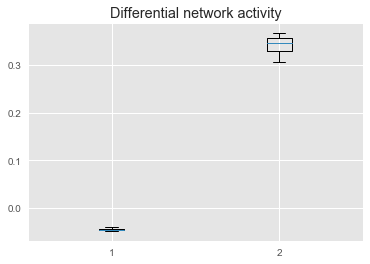

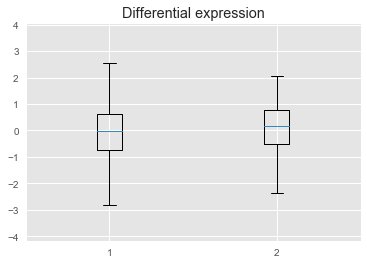

In [246]:
gene = "ENSG00000185591"
regulons_ = [key for key in regulonModules.keys() if gene in regulonModules[key]]
#regulons_ = np.array(list(set(regulonDf[regulonDf.Regulator==gene]["Regulon_ID"]))).astype(str)

reference_matrix = eigengenes.copy()

baseline_regulons = []
first_relapse_regulons = []
multiple_relapse_regulons = []
relapse_regulons = []

for regulon_ in regulons_:
    r, p = stats.spearmanr(expressionData.loc[gene,reference_matrix.columns],reference_matrix.loc[regulon_,:])
    edge_direction = r/np.abs(float(r))
    #edge_direction = 1
    #baseline_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],baseline_patients],axis=0))
    #relapse_values = np.mean(np.mean(expressionData.loc[regulonModules[regulon_],relapse_patients],axis=0))
    baseline_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype1])
    baseline_regulons.append(baseline_values)
    relapse_values = edge_direction*np.mean(reference_matrix.loc[regulon_,phenotype2])
    relapse_regulons.append(relapse_values)    
    print(relapse_values)

plt.boxplot([baseline_regulons,relapse_regulons])
plt.title("Differential network activity")
plt.figure()
plt.boxplot([expressionData.loc[gene,phenotype1],expressionData.loc[gene,phenotype2]])
plt.title("Differential expression")

completed in 3.62 minutes


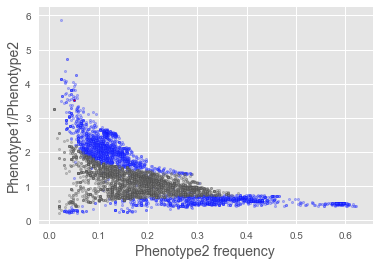

In [247]:
reload(miner)
ikzf1 = "ENSG00000185811"
genes_to_highlight = [ikzf1]
volcano_data_all = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = None,minRegulons = 2,useAllRegulons = True,highlight = genes_to_highlight,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_all_regulons.pdf"))

completed in 2.94 minutes


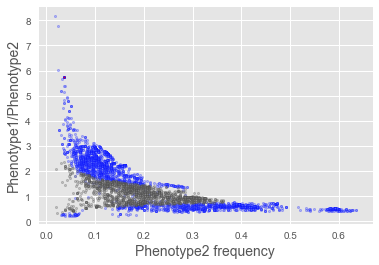

In [248]:
reload(miner)
volcano_data_3 = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False,highlight = genes_to_highlight,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_top3regulons.pdf"))

completed in 2.45 minutes


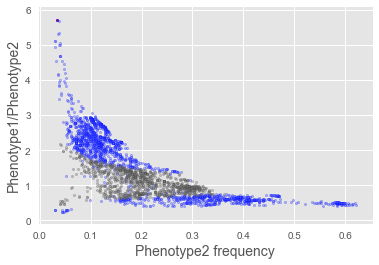

In [249]:
reload(miner)
volcano_data_5 = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 5,minRegulons = 5,useAllRegulons = False,highlight = genes_to_highlight,savefile = os.path.join(resultsDirectory,"baseline_vs_relapse_top5regulons.pdf"))

In [250]:
volcano_df = volcano_data_5.copy()
volcano_df.sort_values(by="phenotype1/phenotype2",ascending=False,inplace=True)
miner.gene_conversion(volcano_df.index[-20:],list_symbols=True)

querying 1-20...done.
Finished.
1 input query terms found no hit:
	[u'ENSG00000133808']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[u'CBX5',
 u'SRXN1',
 u'DARS2',
 u'MRPL47',
 u'RAB38',
 u'SGMS2',
 u'LY6K',
 u'AFAP1L2',
 u'NR2F1',
 u'PDE7B',
 u'PCOLCE2',
 u'SH3PXD2B',
 u'CD226',
 u'XRCC1',
 nan,
 u'BCL11B',
 u'DACT1',
 u'TLN1',
 u'HOXA9',
 u'DPYS']

# Visualize with tSNE

In [ ]:
t1 = time.time()

# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
# miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)
# plt.savefig(os.path.join(resultsDirectory,"tsne_gene_expression.pdf"),bbox_inches="tight")

# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = mosaicDf.copy()
plt.figure()
X_embedded = miner.tsne(df_for_tsne,perplexity=30,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
plt.savefig(os.path.join(resultsDirectory,"tsne_regulon_activity.pdf"),bbox_inches="tight")

# convert states to tsne labels

state_labels = miner.tsneStateLabels(tsneDf,states)

# overlay states cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=state_labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_states.pdf"),bbox_inches="tight")

# overlay activity of transcriptional programs
miner.plotStates(statesDf,tsneDf,numCols=int(np.sqrt(statesDf.shape[0])),saveFile = os.path.join(resultsDirectory,("_").join(["states_regulons",("").join(["0o",str(minCorrelation).split(".")[1]]),"tsne.pdf"])),aspect=1,size=10,scale=3)

t2 = time.time()
print("completed tsne visualization in {:.2f} minutes".format((t2-t1)/60.))


# Plot risk by states

20
completed transcriptional state survival analysis in 0.53 minutes


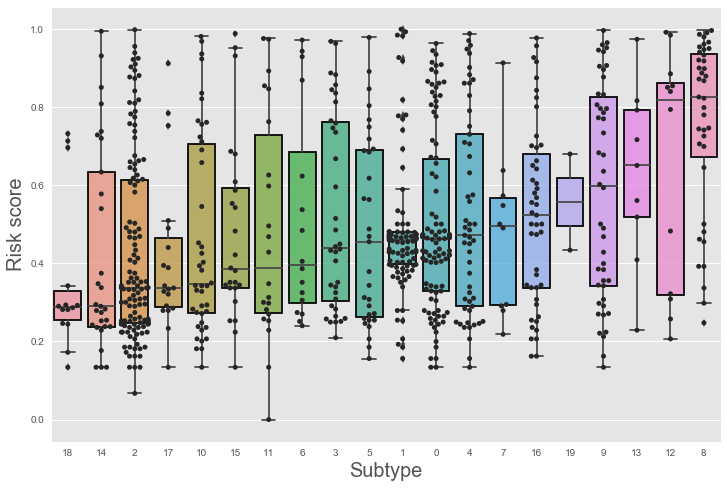

In [147]:
t1 = time.time()

# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = states
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='group', y='value', data=guan_srv_df,order=ranked_states)
for patch in ax.artists:
    patch.set_edgecolor('black')
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=5, color=[0.15,0.15,0.15],edgecolor="black")
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"boxplot_swarm.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


# proportional hazards regression of transcriptional programs
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_programs_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_programs_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_programs_df = pd.DataFrame(np.vstack([cox_programs_hr,cox_programs_p]).T)
cox_programs_df.index = [cox_programs.keys()[i] for i in range(len(cox_programs))]
cox_programs_df.columns = ["HR","p-value"]
cox_programs_df.sort_values(by="HR",ascending=False,inplace=True)

# proportional hazards regression of transcriptional states
state_members = [states[i] for i in range(len(states)) if len(states[i])>=9]
sufficient_states = [i for i in range(len(states)) if len(states[i])>=9]
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=5,survivalPath="",survivalData=srv)

cox_hr = [cox_states[i][0] for i in cox_states.keys()]
cox_p = [cox_states[i][1] for i in cox_states.keys()]
cox_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_df.index = cox_states.keys()
cox_df.columns = ["HR","p-value"]
cox_df.sort_values(by="HR",ascending=False,inplace=True)

t2 = time.time()
print("completed transcriptional state survival analysis in {:.2f} minutes".format((t2-t1)/60.))

# Analyze tf activity (in progress)

In [ ]:
tf_inDegree = Counter(regulonDf.Regulator)

In [ ]:
tf_outDegree_genes = {}
for reg in list(regulonDf.Regulator.unique()):
    regdf_subset = regulonDf[regulonDf.Regulator==reg]
    tf_outDegree_genes[reg] = len(regdf_subset.Gene.unique())
    
print(tf_outDegree_genes["ENSG00000112592"])

In [ ]:
tf_inDegree_genes = {}
for reg in list(regulonDf.Regulator.unique()):
    try:
        regdf_subset = regulonDf[regulonDf.Gene==reg]
        degree = len(regdf_subset.Regulator.unique())
        tf_inDegree_genes[reg] = degree
    except:
        tf_inDegree_genes[reg] = 0
        
    
print(tf_inDegree_genes["ENSG00000112592"])

In [ ]:
gene = "ENSG00000185591"
reference_matrix = eigengenes.copy()
downstream_activity = []
upstream_activity = []
downstream_tfs = []
upstream_tfs = []

for gene in list(set(regulonDf.Regulator.unique())):
    regulons_out = []
    regulons_ = np.array(list(set(regulonDf[regulonDf.Regulator==gene]["Regulon_ID"]))).astype(str)
    for regulon_ in regulons_:
        r, p = stats.spearmanr(expressionData.loc[gene,reference_matrix.columns],reference_matrix.loc[regulon_,:])
        edge_direction = r/np.abs(float(r))
        relapse_values = list(edge_direction*reference_matrix.loc[regulon_,:])
        regulons_out.append(relapse_values)     

    outward = np.mean(np.vstack(regulons_out),axis=0)
    downstream_activity.append(outward)
    downstream_tfs.append(gene)

    regulons_in = []
    regulons_ = np.array(list(set(regulonDf[regulonDf.Gene==gene]["Regulon_ID"]))).astype(str)
    if len(regulons_) >0: 
        for regulon_ in regulons_:
            relapse_values = list(reference_matrix.loc[regulon_,:])
            regulons_in.append(relapse_values)    

        inward = np.mean(np.vstack(regulons_in),axis=0)
        upstream_activity.append(inward)
        upstream_tfs.append(gene)

tf_downstream_activity = pd.DataFrame(np.vstack(downstream_activity))
tf_downstream_activity.index = downstream_tfs
tf_downstream_activity.columns = reference_matrix.columns

tf_upstream_activity = pd.DataFrame(np.vstack(upstream_activity))
tf_upstream_activity.index = upstream_tfs
tf_upstream_activity.columns = reference_matrix.columns


In [ ]:
tf_upstream_activity

In [ ]:
reload(miner)
survival_results_downstream = miner.parallelSurvivalAnalysis(tf_downstream_activity,survivalDfMMRF,numCores=5)
survival_results_upstream = miner.parallelSurvivalAnalysis(tf_upstream_activity,survivalDfMMRF,numCores=5)

In [ ]:
common_keys = list(set(survival_results_downstream.keys())&set(survival_results_upstream.keys()))

In [ ]:
survival_values_downstream = [survival_results_downstream[key][0] for key in common_keys]
survival_values_upstream = [survival_results_upstream[key][0] for key in common_keys]
plt.scatter(survival_values_upstream,survival_values_downstream)

In [ ]:
survival_upstream_results_df = pd.DataFrame(survival_results_upstream)
survival_upstream_results_df.index = survival_results_upstream.keys()
survival_upstream_results_df.columns = ["upstream_hazard"]

survival_downstream_results_df = pd.DataFrame(survival_results_downstream)
survival_downstream_results_df.index = survival_results_downstream.keys()
survival_downstream_results_df.columns = ["downstream_hazard"]

In [ ]:
# infer impact of mutations of epigenetic regulators
epigenetic_file = os.path.join(os.path.split(os.getcwd())[0],"data","epigenes.txt")
epigenetic_regulators = pd.read_csv(epigenetic_file,index_col=None,header=None,sep="\t")
epigenetic_regulators = list(epigenetic_regulators[0])
epigenetic_impact = miner.causalNetworkImpact(epigenetic_regulators,regulonDf,expressionData,eigengenes,translocations,resultsDirectory,minRegulons=1,significance_threshold=0.05,causalFolder="epigenetic_results",return_df=True,tag=None)

In [ ]:
survival_upstream_results_df

In [ ]:
test1 = survival_upstream_results_df.index[np.where(survival_upstream_results_df.iloc[:,0]>-1)[0]]
test2 = survival_downstream_results_df.index[np.where(survival_downstream_results_df.iloc[:,0]<-2)[0]]
print(list(set(test1)&set(test2)))

In [ ]:
miner.gene_conversion(survival_downstream_results_df.index[np.where(survival_downstream_results_df.iloc[:,0]>4)[0]],list_symbols=True)

In [ ]:
gene_dependency = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","gene_dependency_corrected.csv"),index_col=0,header=0)

In [ ]:
gene_dependency.index

In [ ]:
gene_dependency_celllines = pd.read_csv(os.path.join(os.path.split(os.getcwd())[0],"data","DepMap-2019q1-celllines_v2.csv"),index_col=0,header=0)
myeloma_cell_lines_df = gene_dependency_celllines[gene_dependency_celllines["Primary Disease"]=="Myeloma"]
myeloma_cell_lines = list(myeloma_cell_lines_df.index)
myeloma_cell_lines_df.loc["ACH-000576",:]

In [ ]:
myeloma_gene_dependency = gene_dependency.loc[list(set(set(gene_dependency.index)&set(myeloma_cell_lines))),:]
myeloma_gene_dependency["TEAD1 (7003)"]

In [ ]:
# tfActivity_expression
# tfActivity_incoming
# tfActivity_outgoing
# tfActivity_leastSquares

sp1_out = pd.DataFrame(sp1_outward)
sp1_out.index = expressionData.columns
sp1_out.columns = ["tfActivity_outdegree"]

plt.figure()
plt.boxplot([expressionData.loc[gene,baseline_patients],expressionData.loc[gene,relapse_patients]])

plt.figure()
plt.boxplot([sp1_in.loc[baseline_patients,"tfActivity_indegree"],sp1_in.loc[relapse_patients,"tfActivity_indegree"]])

if len(regulons_) >0: 
    sp1_in = pd.DataFrame(sp1_inward)
    sp1_in.index = expressionData.columns
    sp1_in.columns = ["tfActivity_indegree"]

    plt.figure()
    plt.boxplot([sp1_out.loc[baseline_patients,"tfActivity_outdegree"],sp1_out.loc[relapse_patients,"tfActivity_outdegree"]])


In [ ]:
transcriptionFactors = list(regulonDf.Regulator.unique())
tfActivity_inDegree = miner.causalNetworkImpact(epigenetic_regulators,regulonDf,expressionData,eigengenes,translocations,resultsDirectory,minRegulons=1,significance_threshold=0.05,causalFolder="epigenetic_results",return_df=True,tag=None)